# Loading libraries

In [2]:
%pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error as msle
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Overview modeling

1. Tổng qua về data fit vào training 
    * Dữ liệu training: 01/1/2013 - 15/8/2017
    * Dữ liệu test: 16/8/2017 - 31/8/2017
    * Dữ liệu test thì bị thiếu trường thông tin **sale** và đây là trường mà chúng ta cần dự báo 
2. Chiến lược training của tác giả 
    * Chúng ta có 54 cửa hàng, và mỗi cửa hàng có 33 mặt hàng 
    * Tác giả xây dựng một mô hình có thể training mỗi mặt hàng trong từng cửa hàng đó xong rồi đánh giá với tập dữ liệu test. 
    * Tổng ta có cả hết là 54x33 = 1782 mô hình khác nhau chỗ mỗi mặt hàng tại mỗi cửa hàng 
3. Chiến lược đánh giá 
    * Training mô hình xong, đưa ra kết quả dự đoán dựa trên id, trong id đó sẽ đặc trưng cho mặt hàng nào và cửa hàng nào. Từ đó chúng ta có thể lựa chọn được 1 trong số 1782 mô hình để đưa ra được kết quả có độ chính xác cao nhất. 
    * Kết quả sau khi được training xong được đánh giá bằng cách đưa lên kaggle để hệ thống đánh giá điểm score RMSE 
    * Một ý tưởng để việc đánh giá có thể diễn ra nhanh hơn, sử dụng y_pred của giải pháp tốt nhất trên kaggle làm ground truth
4. Đưa ra một số giải pháp để tuning các parameter 
    * Thay đổi một số mô hình trong số các mô hình Machine learning cơ bản sau: 
        * Linear Regression 
        * KNN
        * Random Forest 
        * ...
    * Với mỗi mô hình thay đổi từng tham số parameter 


# Support Function 

### split_func

In [3]:
def split_func (orig_df, X, y, test_size, shuffle = False):
    # Splitting train and test
    idx_train, idx_test = train_test_split(orig_df.index, test_size=test_size, shuffle=shuffle )
    X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
    y_train, y_test = y.loc[idx_train], y.loc[idx_test]
    
    return X_train, y_train, X_test, y_test

### my_split_func

In [4]:
def my_split_func(df, train_start_date='2013-01-01', train_end_date='2017-08-30',
               val_start_date='2017-09-01', val_end_date='2020-01-01'):
    train_start_date = (pd.to_datetime(train_start_date) - pd.to_datetime('2013-01-01')).days
    train_end_date = (pd.to_datetime(train_end_date) - pd.to_datetime('2013-01-01')).days
    val_start_date = (pd.to_datetime(val_start_date) - pd.to_datetime('2013-01-01')).days
    val_end_date = (pd.to_datetime(val_end_date) - pd.to_datetime('2013-01-01')).days
    
    train = df[(df['days_from_2013'] >= train_start_date) & (df['days_from_2013'] <= train_end_date)]
    val = df[(df['days_from_2013'] >= val_start_date) & (df['days_from_2013'] <= val_end_date)]
    return [train.drop(columns=['sales']), val.drop(columns=['sales']), train['sales'], val['sales']]

### learning_curves

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 

random_state = 42
%pwd
### Bundling our previous work into a function ###
def learning_curves(estimator, X_train, y_train):
    train_sizes, train_scores, validation_scores = learning_curve( estimator, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()


    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="f1")
    # Lấy trung bình cộng các giá trị output của các fold 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label=label_curve['test'])
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
             label=label_curve['train'])

    plt.legend(loc="best")
    return plt 

### Grid_Search_CV_RFR

In [6]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

def RFR(X_train, X_test, y_train, y_test, best_params):
    from sklearn.ensemble import RandomForestRegressor
    estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    print ("R2 score:",r2(y_test,y_predict))
    return y_test,y_predict


### get_weights_distribution

In [7]:
def get_weights_distribution(tp, dates):
    if tp == 1:
        return np.ones(dates.shape)
    if tp == 2:
        return np.exp((400 - (pd.to_datetime('2017-08-16') - pd.to_datetime(dates)).days) / 100)
    if tp == 3:
        return np.exp((400 - (pd.to_datetime('2017-08-16') - pd.to_datetime(dates)).days) / 200)
    if tp == 4:
        return np.exp((400 - (pd.to_datetime('2017-08-16') - pd.to_datetime(dates)).days) / 300)
    if tp == 5:
        return np.exp((400 - (pd.to_datetime('2017-08-16') - pd.to_datetime(dates)).days) / 400)

In [8]:
def plot_learning_curve(estimator, title, label_curve, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), new_plot=False,
                        idx_color=0):
    # Khởi tạo bức ảnh mới với thư viện plot lib 
    if new_plot:
        # plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()
    # chú thích nếu có 
    if ylim is not None:
        plt.ylim(*ylim)
        
    # thực hiện training model, ghi nhận các giá trị trong quá trình training 
    # cv = số fold cross validate, số phần bộ dữ liệu được chia để thực hiện training testing.
    # train_sizes = mảng tỉ lệ, các tỉ lệ được hệ thống chọn làm điểm dừng để thực hiện 1 testing 
    #  train_sizes = [0.3, 0.5] => hệ thống lấy 30 % dữ liệu để train và thực hiện test, tương tự 50 % ..
    # scoring = hàm mục tiêu để đánh giá chất lượng mô hình và vẽ lên đồ thị 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'neg_mean_squared_error')
    # Lấy trung bình cộng các giá trị output của các fold 
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)
    plt.figure(figsize = (12,9))
    
    # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label=label_curve['test'])
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
             label=label_curve['train'])

    plt.legend(loc="best")
    return plt 

### Str_to_num

In [9]:
def str_to_num(data):
    data1 = data.dropna().unique()
    lis = range(1,len(data1)+1)
    zipper = dict(zip(data1,lis))
    print(zipper)
    liss = []
    for ele in data:
        x = zipper[ele]
        liss.append(x)
    return liss

# Load data

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
df = pd.read_csv('/content/gdrive/MyDrive/VinBigData/Machine learning/Project/data.csv', index_col = [0,1,2] ) 
df

id  sales  onpromotion  cluster  \
store_nbr family     date                                               
1         AUTOMOTIVE 2016-06-01  2216808    3.0            0       13   
                     2016-06-02  2218590    1.0            0       13   
                     2016-06-03  2220372    4.0            0       13   
                     2016-06-04  2222154    9.0            0       13   
                     2016-06-05  2223936    2.0            0       13   
...                                  ...    ...          ...      ...   
54        SEAFOOD    2017-08-27  3022139    NaN            0        3   
                     2017-08-28  3023921    NaN            0        3   
                     2017-08-29  3025703    NaN            0        3   
                     2017-08-30  3027485    NaN            0        3   
                     2017-08-31  3029267    NaN            0        3   

                                 uniquestore  newstore  firstday  isclosed  \
store_nbr family     date                                                    
1         AUTOMOTIVE 2016-06-01            0         0         0         0   
                     2016-06-02            0         0         0         0   
                     2016-06-03            0         0         0         0   
                     2016-06-04            0         0         0         0   
                     2016-06-05            0         0         0         0   
...                                      ...       ...       ...       ...   
54        SEAFOOD    2017-08-27            1         0         0         0   
                     2017-08-28            1         0         0         0   
                     2017-08-29            1         0         0         0   
                     2017-08-30            1         0         0         0   
                     2017-08-31            1         0         0         0   

                                 dcoilwtico  lagoil_1_dcoilwtico  ...  \
store_nbr family     date                                         ...   
1         AUTOMOTIVE 2016-06-01   49.070000            49.100000  ...   
                     2016-06-02   49.140000            49.070000  ...   
                     2016-06-03   48.690000            49.140000  ...   
                     2016-06-04   49.030000            48.690000  ...   
                     2016-06-05   49.370000            49.030000  ...   
...                                     ...                  ...  ...   
54        SEAFOOD    2017-08-27   46.816667            47.233333  ...   
                     2017-08-28   46.400000            46.816667  ...   
                     2017-08-29   46.460000            46.400000  ...   
                     2017-08-30   45.960000            46.460000  ...   
                     2017-08-31   47.260000            45.960000  ...   

                                 trans_lagged365  tag_sex  tag_luxury  \
store_nbr family     date                                               
1         AUTOMOTIVE 2016-06-01                0        4           7   
                     2016-06-02                0        4           7   
                     2016-06-03                0        4           7   
                     2016-06-04                0        4           7   
                     2016-06-05                0        4           7   
...                                          ...      ...         ...   
54        SEAFOOD    2017-08-27                0       -5           8   
                     2017-08-28                0       -5           8   
                     2017-08-29                0       -5           8   
                     2017-08-30                0       -5           8   
                     2017-08-31                0       -5           8   

                                 tag_age_mean  tag_age_var  tag_type_family  \
store_nbr family     date                                                     
1         AUTOM

In [12]:
good_p = [{'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9733,
  'max_features': 'auto',
  'max_leaf_nodes': 4730,
  'n_estimators': 159,
  'min_samples_split': 3,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 3637,
  'max_features': 'auto',
  'max_leaf_nodes': 5844,
  'n_estimators': 927,
  'min_samples_split': 19,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5062,
  'max_features': 'auto',
  'max_leaf_nodes': 5517,
  'n_estimators': 802,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 3464,
  'max_features': 'auto',
  'max_leaf_nodes': 6557,
  'n_estimators': 831,
  'min_samples_split': 18,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9643,
  'max_features': 'auto',
  'max_leaf_nodes': 3637,
  'n_estimators': 602,
  'min_samples_split': 8,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5776,
  'max_features': 'auto',
  'max_leaf_nodes': 5125,
  'n_estimators': 850,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 4385,
  'max_features': 'auto',
  'max_leaf_nodes': 5692,
  'n_estimators': 622,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9517,
  'max_features': 'auto',
  'max_leaf_nodes': 5239,
  'n_estimators': 154,
  'min_samples_split': 3,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9974,
  'max_features': 'auto',
  'max_leaf_nodes': 1802,
  'n_estimators': 286,
  'min_samples_split': 8,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 8942,
  'max_features': 'auto',
  'max_leaf_nodes': 3263,
  'n_estimators': 356,
  'min_samples_split': 14,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5629,
  'max_features': 'auto',
  'max_leaf_nodes': 4907,
  'n_estimators': 586,
  'min_samples_split': 20,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5292,
  'max_features': 'auto',
  'max_leaf_nodes': 5194,
  'n_estimators': 885,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 3123,
  'max_features': 'auto',
  'max_leaf_nodes': 5206,
  'n_estimators': 814,
  'min_samples_split': 7,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 4363,
  'max_features': 'auto',
  'max_leaf_nodes': 5692,
  'n_estimators': 816,
  'min_samples_split': 19,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5159,
  'max_features': 'auto',
  'max_leaf_nodes': 5510,
  'n_estimators': 863,
  'min_samples_split': 19,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9640,
  'max_features': 'auto',
  'max_leaf_nodes': 3074,
  'n_estimators': 631,
  'min_samples_split': 2,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 3227,
  'max_features': 'auto',
  'max_leaf_nodes': 6524,
  'n_estimators': 931,
  'min_samples_split': 19,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5503,
  'max_features': 'auto',
  'max_leaf_nodes': 5540,
  'n_estimators': 813,
  'min_samples_split': 19,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 2388,
  'max_features': 'auto',
  'max_leaf_nodes': 5413,
  'n_estimators': 842,
  'min_samples_split': 6,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9395,
  'max_features': 'auto',
  'max_leaf_nodes': 2736,
  'n_estimators': 549,
  'min_samples_split': 3,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5346,
  'max_features': 'auto',
  'max_leaf_nodes': 4506,
  'n_estimators': 600,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5633,
  'max_features': 'auto',
  'max_leaf_nodes': 5546,
  'n_estimators': 802,
  'min_samples_split': 19,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9638,
  'max_features': 'auto',
  'max_leaf_nodes': 3230,
  'n_estimators': 347,
  'min_samples_split': 10,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 8900,
  'max_features': 'auto',
  'max_leaf_nodes': 3277,
  'n_estimators': 604,
  'min_samples_split': 12,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9684,
  'max_features': 'auto',
  'max_leaf_nodes': 6188,
  'n_estimators': 151,
  'min_samples_split': 3,
  'min_samples_leaf': 7},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 4280,
  'max_features': 'auto',
  'max_leaf_nodes': 5767,
  'n_estimators': 582,
  'min_samples_split': 19,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5492,
  'max_features': 'auto',
  'max_leaf_nodes': 7085,
  'n_estimators': 928,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9442,
  'max_features': 'auto',
  'max_leaf_nodes': 3015,
  'n_estimators': 571,
  'min_samples_split': 19,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9229,
  'max_features': 'auto',
  'max_leaf_nodes': 2628,
  'n_estimators': 724,
  'min_samples_split': 14,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 8943,
  'max_features': 'auto',
  'max_leaf_nodes': 3268,
  'n_estimators': 552,
  'min_samples_split': 12,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5048,
  'max_features': 'auto',
  'max_leaf_nodes': 5318,
  'n_estimators': 841,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 4811,
  'max_features': 'auto',
  'max_leaf_nodes': 4645,
  'n_estimators': 862,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9948,
  'max_features': 'auto',
  'max_leaf_nodes': 2266,
  'n_estimators': 478,
  'min_samples_split': 2,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9082,
  'max_features': 'auto',
  'max_leaf_nodes': 2578,
  'n_estimators': 771,
  'min_samples_split': 16,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9473,
  'max_features': 'auto',
  'max_leaf_nodes': 4595,
  'n_estimators': 601,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 2596,
  'max_features': 'auto',
  'max_leaf_nodes': 5962,
  'n_estimators': 826,
  'min_samples_split': 19,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 7853,
  'max_features': 'auto',
  'max_leaf_nodes': 3855,
  'n_estimators': 540,
  'min_samples_split': 12,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9124,
  'max_features': 'auto',
  'max_leaf_nodes': 3312,
  'n_estimators': 561,
  'min_samples_split': 12,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5893,
  'max_features': 'auto',
  'max_leaf_nodes': 7028,
  'n_estimators': 900,
  'min_samples_split': 18,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 4892,
  'max_features': 'auto',
  'max_leaf_nodes': 5583,
  'n_estimators': 817,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 8662,
  'max_features': 'auto',
  'max_leaf_nodes': 2555,
  'n_estimators': 603,
  'min_samples_split': 2,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9399,
  'max_features': 'auto',
  'max_leaf_nodes': 5406,
  'n_estimators': 476,
  'min_samples_split': 8,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5676,
  'max_features': 'auto',
  'max_leaf_nodes': 5010,
  'n_estimators': 910,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 8670,
  'max_features': 'auto',
  'max_leaf_nodes': 2466,
  'n_estimators': 615,
  'min_samples_split': 2,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9504,
  'max_features': 'auto',
  'max_leaf_nodes': 4756,
  'n_estimators': 174,
  'min_samples_split': 3,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5425,
  'max_features': 'auto',
  'max_leaf_nodes': 4880,
  'n_estimators': 593,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 3110,
  'max_features': 'auto',
  'max_leaf_nodes': 6680,
  'n_estimators': 900,
  'min_samples_split': 18,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 7487,
  'max_features': 'auto',
  'max_leaf_nodes': 2261,
  'n_estimators': 619,
  'min_samples_split': 2,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9159,
  'max_features': 'auto',
  'max_leaf_nodes': 1792,
  'n_estimators': 650,
  'min_samples_split': 2,
  'min_samples_leaf': 7},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5681,
  'max_features': 'auto',
  'max_leaf_nodes': 5128,
  'n_estimators': 865,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 8890,
  'max_features': 'auto',
  'max_leaf_nodes': 4136,
  'n_estimators': 652,
  'min_samples_split': 2,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5616,
  'max_features': 'auto',
  'max_leaf_nodes': 5129,
  'n_estimators': 805,
  'min_samples_split': 19,
  'min_samples_leaf': 7},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9610,
  'max_features': 'auto',
  'max_leaf_nodes': 3832,
  'n_estimators': 537,
  'min_samples_split': 3,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 7895,
  'max_features': 'auto',
  'max_leaf_nodes': 2550,
  'n_estimators': 547,
  'min_samples_split': 7,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9542,
  'max_features': 'auto',
  'max_leaf_nodes': 4330,
  'n_estimators': 138,
  'min_samples_split': 12,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9248,
  'max_features': 'auto',
  'max_leaf_nodes': 3167,
  'n_estimators': 725,
  'min_samples_split': 9,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9384,
  'max_features': 'auto',
  'max_leaf_nodes': 2723,
  'n_estimators': 542,
  'min_samples_split': 8,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9690,
  'max_features': 'auto',
  'max_leaf_nodes': 3295,
  'n_estimators': 580,
  'min_samples_split': 14,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9740,
  'max_features': 'auto',
  'max_leaf_nodes': 2422,
  'n_estimators': 226,
  'min_samples_split': 12,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 5135,
  'max_features': 'auto',
  'max_leaf_nodes': 4734,
  'n_estimators': 801,
  'min_samples_split': 20,
  'min_samples_leaf': 8},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 7858,
  'max_features': 'auto',
  'max_leaf_nodes': 1368,
  'n_estimators': 588,
  'min_samples_split': 4,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 4094,
  'max_features': 'auto',
  'max_leaf_nodes': 5658,
  'n_estimators': 605,
  'min_samples_split': 20,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 8659,
  'max_features': 'auto',
  'max_leaf_nodes': 2678,
  'n_estimators': 669,
  'min_samples_split': 3,
  'min_samples_leaf': 9},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 7750,
  'max_features': 'auto',
  'max_leaf_nodes': 3738,
  'n_estimators': 703,
  'min_samples_split': 13,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9805,
  'max_features': 'auto',
  'max_leaf_nodes': 3020,
  'n_estimators': 716,
  'min_samples_split': 14,
  'min_samples_leaf': 10},
 {'criterion': 'squared_error',
  'bootstrap': 'False',
  'max_depth': 9567,
  'max_features': 'auto',
  'max_leaf_nodes': 2948,
  'n_estimators': 223,
  'min_samples_split': 12,
  'min_samples_leaf': 10}]

In [13]:
ss = pd.read_csv('/content/gdrive/MyDrive/VinBigData/Machine learning/Project/data/sample_submission.csv')

In [14]:
df.index.get_level_values(0).unique()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54],
           dtype='int64', name='store_nbr')

In [15]:
df.index.get_level_values(1).unique()


Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object', name='family')

In [16]:
Y_test = pd.read_csv('/content/gdrive/MyDrive/VinBigData/Machine learning/Project/submission_best.csv') 


# Strategy 1: Training theo từng mặt hàng của từng cửa hàng 55x33 models 

### Step1: Test model




RF: 0.3742303330766315
LG: 0.3947800427820736


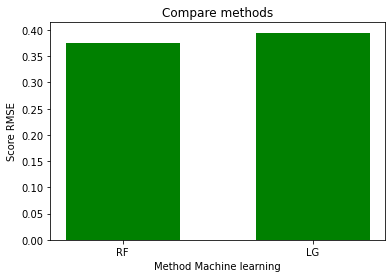

In [ ]:
sm_rf = 0
sm_lg = 0
cnt = 0
import warnings
warnings.filterwarnings('ignore')
i = df.index.get_level_values(0).unique()[0]
for j in df.index.get_level_values(1).unique():
    df_ = df.loc[(i, j)]
    test_data = df_[df_['sales'].isna()]
    df_ = df_.drop(columns=['id', 'transactions'])
    train = df_[~df_['sales'].isna()]
    train.dropna()
    #train.dropna()
    X = train.drop(['sales'], axis =1 )
    y = train['sales'] 
    X.shape, y.shape
    X_train, y_train, X_val , y_val = split_func (train, X , y, test_size = 0.2,  shuffle = False) 

    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)

    weights = np.exp((400 - (pd.to_datetime('2017-08-16') - pd.to_datetime(X_train.index)).days) / 200)
    weights = weights.to_numpy()

    model = RandomForestRegressor()
    model.fit(X_train.values, y_train.values, sample_weight=weights)
    preds = model.predict(X_val)
    sm_rf += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))

    model = LGBMRegressor()
    model.fit(X_train.to_numpy(), y_train, sample_weight=weights)
    preds = model.predict(X_val)
    sm_lg += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))

    cnt += 1
print("RF:", (sm_rf / cnt)**0.5)
print("LG:", (sm_lg / cnt)**0.5)
scores = [ (sm_rf / cnt)**0.5 , (sm_lg / cnt)**0.5]
labels = ['RF','LG'] 
# creating the bar plot
plt.bar(labels, scores, color ='green', width = 0.6)
plt.xlabel("Method Machine learning")
plt.ylabel("Score RMSE")
plt.title("Compare methods")
plt.show()

### Step 2: Lựa chọn best kiến trúc

In [ ]:
sm_gb = 0
sm_lr = 0
sm_rf = 0
sm_xg = 0
sm_lg = 0
sm_cb = 0

cnt = 0
for i in tqdm(df.index.get_level_values(0).unique()):
    for j in df.index.get_level_values(1).unique():
        df_ = df.loc[(i, j)]
        # test_data = df_[df_['sales'].isna()]
        df_ = df_.drop(columns=['id', 'transactions'])
        
        train = df_[~df_['sales'].isna()]
        train.dropna()
        #train.dropna()
        X = train.drop(['sales'], axis =1 )
        y = train['sales'] 
        X.shape, y.shape
        X_train, y_train, X_val , y_val = split_func (train, X , y, test_size = 0.2,  shuffle = False) 
        y_train = np.log1p(y_train)
        y_val = np.log1p(y_val)
    
        # y_test = test_data.merge(Y_test, left_on='id', right_on='id')['sales_y']
        # y_test = np.log1p(y_test)
        weights = np.exp((400 - (pd.to_datetime('2017-08-16') - pd.to_datetime(X_train.index)).days) / 200)
        weights = weights.to_numpy()
        
        model = GradientBoostingRegressor()
        model.fit(X_train, y_train, sample_weight=weights)
        preds = model.predict(X_val)
        sm_gb += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
        
        model = LinearRegression()
        model.fit(X_train, y_train, sample_weight=weights)
        preds = model.predict(X_val)
        sm_lr += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
        
        model = RandomForestRegressor()
        model.fit(X_train, y_train, sample_weight=weights)
        preds = model.predict(X_val)
        sm_rf += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
        
        model = XGBRegressor()
        model.fit(X_train, y_train, sample_weight=weights)
        preds = model.predict(X_val)
        sm_xg += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
        
        model = LGBMRegressor()
        model.fit(X_train.to_numpy(), y_train, sample_weight=weights)
        preds = model.predict(X_val)
        sm_lg += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
        
        
        #P = Pool(X_train.to_numpy(), y_train, weight=weights)

        
        # model = CatBoostRegressor()
        # model.fit(X_train, y_train, verbose=0)
        # preds = model.predict(X_test)
        sm_cb += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
        
        cnt += 1
        #print(msle(np.exp(y_val) - 1,(np.exp(preds) - 1).clip(0), squared=False))
    print("GB:", (sm_gb / cnt)**0.5)
    print("RF:", (sm_rf / cnt)**0.5)
    print("LR:", (sm_lr / cnt)**0.5)
    print("XG:", (sm_xg / cnt)**0.5)
    print("LG:", (sm_lg / cnt)**0.5)


    # print("CB:", (sm_cb / cnt)**0.5)
    break
#print((sm / cnt)**0.5)

  0%|          | 0/54 [00:00<?, ?it/s]

[05:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

  0%|          | 0/54 [01:22<?, ?it/s]

GB: 0.3888224175185954
RF: 0.3767473383137528
LR: 1.319410143822232
XG: 0.3870991591114694
LG: 0.3947800427820736


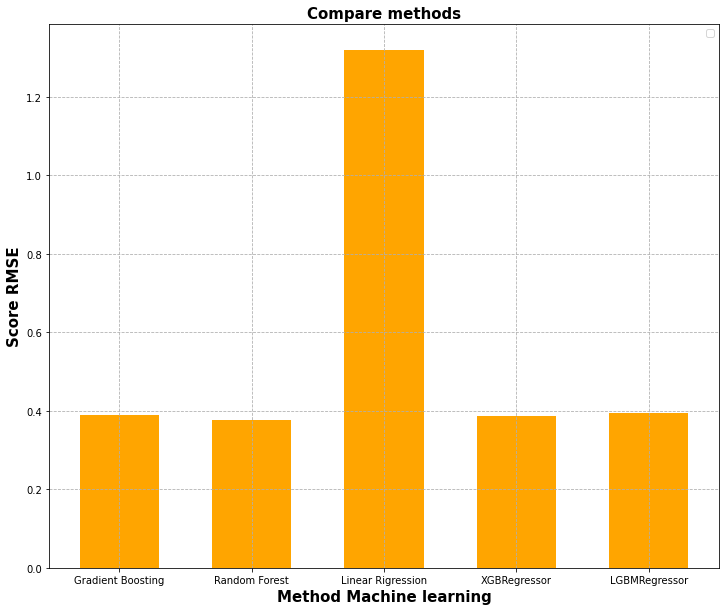

In [ ]:
    scores = [(sm_gb / cnt)**0.5, (sm_rf / cnt)**0.5,(sm_lr / cnt)**0.5, (sm_xg / cnt)**0.5, (sm_lg / cnt)**0.5 ]
    labels = ['Gradient Boosting','Random Forest','Linear Rigression','XGBRegressor','LGBMRegressor'] 
    # creating the bar plot
    plt.figure(figsize=(12,10))
    plt.bar(labels, scores, color ='orange', width = 0.6)
    plt.xlabel("Method Machine learning",fontdict={'fontname':'Comic Sans MS',
                                                    'fontweight':'bold',
                                                   'fontsize':15})
    plt.title('Compare methods',fontdict={'fontname':'Comic Sans MS',
                                                    'fontweight':'bold',
                                                   'fontsize':15})
    plt.ylabel("Score RMSE",fontdict={'fontname':'Comic Sans MS',
                                                    'fontweight':'bold',
                                                   'fontsize':15})
#plt.xticks(rotation=45)
plt.grid(True,ls='--')

#Hiển thị chú thích trong biểu đồ:
plt.legend()
plt.show()

### Step 3: Tuning Parameter 

In [ ]:
sm_rf = 0
cnt = 0
fin_pred = {}
bestScore = [] 
bestParameter = []
#idStore = df.index.get_level_values(0).unique()
idStore = [1,2,3] 
for i in tqdm(idStore): 
    for j in df.index.get_level_values(1).unique():
        df_ = df.loc[(i, j)]
        test_id = df_[df_['sales'].isna()]['id']
        df_ = df_.drop(columns=['id', 'transactions'])
        train = df_[~df_['sales'].isna()]
        X = train.drop(['sales'], axis =1 )
        y = train['sales'] 
        X.shape, y.shape
        X_train, y_train, X_val , y_val = split_func (train, X , y, test_size = 0.2,  shuffle = False) 
        y_train = np.log1p(y_train)
        #y_test = np.log1p(y_test)
        best_score, best_params = Grid_Search_CV_RFR(X_train, y_train) 
        bestScore.append(best_score)
        bestParameter.append(best_params) 
        print(best_score)
        print(best_params)
        break

  0%|          | 0/3 [00:20<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
sm_rf = 0
cnt = 0
fin_pred = {}
visulizeScore = []
#idStore = df.index.get_level_values(0).unique()
idStore = [1,2,3] 
count = 0 
for i in tqdm(idStore): 
    for j in df.index.get_level_values(1).unique():
        df_ = df.loc[(i, j)]
        test_data = df_[df_['sales'].isna()]
        test_id = df_[df_['sales'].isna()]['id']
        df_ = df_.drop(columns=['id', 'transactions'])

        train = df_[~df_['sales'].isna()]
        X_test = df_[df_['sales'].isna()].drop(columns=['sales'])
        X = train.drop(['sales'], axis =1 )
        y = train['sales'] 
        X.shape, y.shape
        X_train, y_train, X_val , y_val = split_func (train, X , y, test_size = 0.2,  shuffle = False) 
        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)

        model = RandomForestRegressor(n_jobs=-1).set_params(**bestParameter[count])
        weights = get_weights_distribution(5, X_train.index)
        model.fit(X_train, y_train, sample_weight=weights)

        preds = model.predict(X_val)
        preds_ = model.predict(X_test)

        for q in range(preds_.shape[0]):
            fin_pred[test_id[q]] = preds_[q]
        
        sm_rf += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
        cnt += 1
        count +=1 
        break
    print((sm_rf / cnt)**0.5)
    visulizeScore.append((sm_rf / cnt)**0.5) 
print((sm_rf / cnt)**0.5)

In [ ]:
sm_rf = 0
cnt = 0
fin_pred = {}
visulizeScore = []
#idStore = df.index.get_level_values(0).unique()
idStore = [1] 
count = 0 
for i in tqdm(idStore): 
    for j in df.index.get_level_values(1).unique():
        df_ = df.loc[(i, j)]
        test_data = df_[df_['sales'].isna()]
        test_id = df_[df_['sales'].isna()]['id']
        df_ = df_.drop(columns=['id', 'transactions'])

        train = df_[~df_['sales'].isna()]
        X = train.drop(['sales'], axis =1 )
        y = train['sales'] 
        X.shape, y.shape
        X_train, y_train, X_val , y_val = split_func (train, X , y, test_size = 0.2,  shuffle = False) 

        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)

        title = 'Learning with dropped features'
        label_curve = {'train': 'train', 'test':'cv'}

        #model = RandomForestRegressor(**good_p[0], random_state=0)
        estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
        estimator.fit(X_train,y_train)
        plot_learning_curve(estimator, title, label_curve, X_train, y_train, cv=5)
        break
        #learning_curves(model, X_train, y_train )

### Step 4: Final training and test

In [ ]:
sm_rf = 0
cnt = 0
fin_pred = {}
visulizeScore = []
idStore = df.index.get_level_values(0).unique()
#idStore = [1,2,3] 
count = 0 
for i in tqdm(idStore): 
    for j in df.index.get_level_values(1).unique():
        df_ = df.loc[(i, j)]
        test_data = df_[df_['sales'].isna()]
        test_id = df_[df_['sales'].isna()]['id']
        df_ = df_.drop(columns=['id', 'transactions'])

        X_test = df_[df_['sales'].isna()].drop(columns=['sales'])
        train = df_[~df_['sales'].isna()]
        X = train.drop(['sales'], axis =1 )
        y = train['sales'] 
        X.shape, y.shape
        X_train, y_train, X_val , y_val = split_func (train, X , y, test_size = 0.2,  shuffle = False) 

        y_train = np.log1p(y_train)
        #y_test = np.log1p(y_test)
        y_val = np.log1p(y_val)

        model = RandomForestRegressor(**good_p[0], random_state=0)
        weights = get_weights_distribution(5, X_train.index)
        model.fit(X_train, y_train, sample_weight=weights)

        preds = model.predict(X_val)
        preds_ = model.predict(X_test)

        for q in range(preds_.shape[0]):
            fin_pred[test_id[q]] = preds_[q]
        
        sm_rf += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
        cnt += 1
        count +=1 
    print((sm_rf / cnt)**0.5)
    visulizeScore.append((sm_rf / cnt)**0.5) 
print((sm_rf / cnt)**0.5)

labels = np.array(idStore).astype(str)
# creating the bar plot
plt.figure(figsize=(20,8))
plt.bar(labels, visulizeScore, color ='red', width = 0.4)
plt.xlabel("ID Store")
plt.ylabel("Score RMSE")
plt.title("Compare methods")
plt.show()


  2%|▏         | 1/54 [00:45<40:34, 45.94s/it]

0.3668792574373401


  4%|▎         | 2/54 [01:28<38:02, 43.90s/it]

0.3662993960446776


  6%|▌         | 3/54 [02:12<37:22, 43.97s/it]

0.3521044238676025


  7%|▋         | 4/54 [02:56<36:46, 44.14s/it]

0.35207847776793977


  9%|▉         | 5/54 [03:40<35:49, 43.87s/it]

0.35956326209254846


 11%|█         | 6/54 [04:20<33:59, 42.50s/it]

0.35235659730678626


 13%|█▎        | 7/54 [05:03<33:26, 42.69s/it]

0.3530181145479408


 15%|█▍        | 8/54 [05:45<32:36, 42.53s/it]

0.3492869207941494


 17%|█▋        | 9/54 [06:25<31:26, 41.92s/it]

0.358383678085368


 19%|█▊        | 10/54 [07:06<30:20, 41.37s/it]

0.3663204711622803


 20%|██        | 11/54 [07:48<29:50, 41.64s/it]

0.37123221785302785


 22%|██▏       | 12/54 [08:28<28:52, 41.24s/it]

0.3764524087482408


 24%|██▍       | 13/54 [09:07<27:46, 40.64s/it]

0.3839041398824714


 26%|██▌       | 14/54 [09:48<27:02, 40.56s/it]

0.3923090071710801


 28%|██▊       | 15/54 [10:29<26:30, 40.79s/it]

0.39423233730235613


 30%|██▉       | 16/54 [11:09<25:35, 40.40s/it]

0.4019435061290503


 31%|███▏      | 17/54 [11:48<24:45, 40.14s/it]

0.4045058106813443


 33%|███▎      | 18/54 [12:22<22:52, 38.12s/it]

0.40875149190317556


 35%|███▌      | 19/54 [13:03<22:53, 39.23s/it]

0.41286534068058317


 37%|███▋      | 20/54 [13:44<22:33, 39.80s/it]

0.41475516300503895


 39%|███▉      | 21/54 [14:26<22:08, 40.27s/it]

0.41887975589243936


 41%|████      | 22/54 [15:06<21:24, 40.14s/it]

0.4229223521844945


 43%|████▎     | 23/54 [15:48<21:03, 40.76s/it]

0.42235601481086926


 44%|████▍     | 24/54 [16:31<20:45, 41.52s/it]

0.42029356774952303


 46%|████▋     | 25/54 [17:10<19:38, 40.63s/it]

0.42279750581855524


 48%|████▊     | 26/54 [17:52<19:08, 41.03s/it]

0.4269851908647744


 50%|█████     | 27/54 [18:33<18:31, 41.17s/it]

0.42610756411549056


 52%|█████▏    | 28/54 [19:13<17:37, 40.66s/it]

0.4273003057544437


 54%|█████▎    | 29/54 [19:52<16:48, 40.34s/it]

0.4278573522409426


 56%|█████▌    | 30/54 [20:35<16:24, 41.02s/it]

0.4312708985411543


 57%|█████▋    | 31/54 [21:17<15:54, 41.50s/it]

0.4321247932149193


 59%|█████▉    | 32/54 [21:57<14:57, 40.79s/it]

0.43781562343131347


 61%|██████    | 33/54 [22:36<14:06, 40.31s/it]

0.43789936147915876


 63%|██████▎   | 34/54 [23:18<13:39, 40.98s/it]

0.43886712480979423


 65%|██████▍   | 35/54 [23:58<12:50, 40.56s/it]

0.43956460484054194


 67%|██████▋   | 36/54 [24:40<12:15, 40.89s/it]

0.4406513663873084


 69%|██████▊   | 37/54 [25:23<11:49, 41.76s/it]

0.4391784695095401


 70%|███████   | 38/54 [26:05<11:06, 41.67s/it]

0.4382120299118424


 72%|███████▏  | 39/54 [26:47<10:27, 41.83s/it]

0.4378945216922193


 74%|███████▍  | 40/54 [27:28<09:42, 41.58s/it]

0.43764333327511773


 76%|███████▌  | 41/54 [28:09<08:58, 41.44s/it]

0.43783670153215337


 78%|███████▊  | 42/54 [28:50<08:16, 41.35s/it]

0.4361222488705713


 80%|███████▉  | 43/54 [29:30<07:28, 40.77s/it]

0.4401388652895545


 81%|████████▏ | 44/54 [30:11<06:49, 40.95s/it]

0.4384007598762269


 83%|████████▎ | 45/54 [30:52<06:08, 40.98s/it]

0.4373204376766911


 85%|████████▌ | 46/54 [31:33<05:28, 41.07s/it]

0.4360334085959272


 87%|████████▋ | 47/54 [32:14<04:46, 40.94s/it]

0.4355112312088646


 89%|████████▉ | 48/54 [32:55<04:04, 40.82s/it]

0.43429668189578896


 91%|█████████ | 49/54 [33:35<03:23, 40.73s/it]

0.4333406867093326


 93%|█████████▎| 50/54 [34:16<02:42, 40.69s/it]

0.43304985117503775


 94%|█████████▍| 51/54 [34:57<02:02, 40.82s/it]

0.4348135464395135


 96%|█████████▋| 52/54 [35:11<01:05, 32.98s/it]

0.43477615392949187


 98%|█████████▊| 53/54 [35:53<00:35, 35.46s/it]

0.43449938709676783


100%|██████████| 54/54 [36:32<00:00, 40.59s/it]

0.4349564206171193
0.4349564206171193


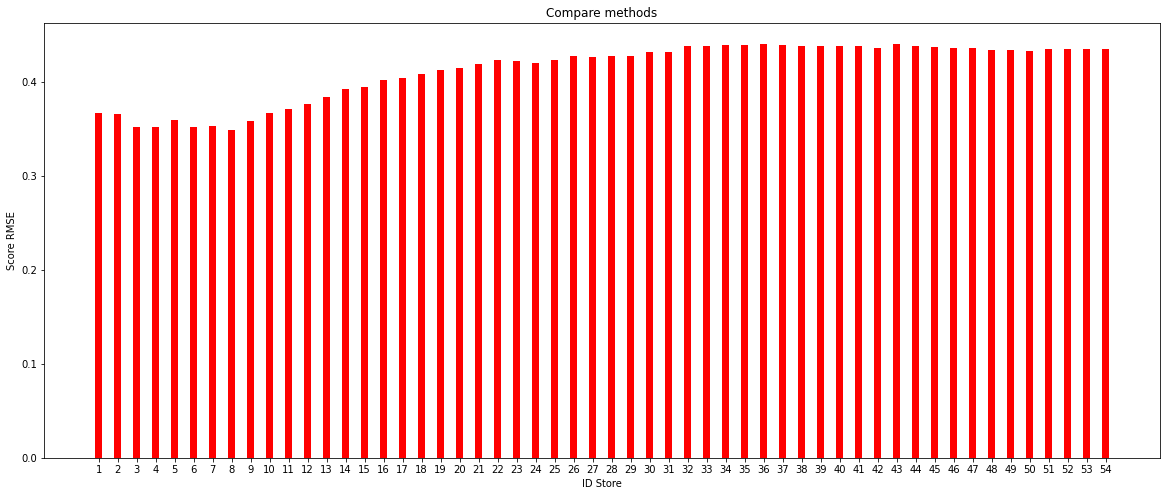

In [ ]:
    labels = np.array(idStore).astype(str)
    # creating the bar plot
    plt.figure(figsize=(20,8))
    plt.bar(labels, visulizeScore, color ='red', width = 0.4)
    plt.xlabel("ID Store")
    plt.ylabel("Score RMSE")
    plt.title("Compare methods")
    plt.show()

# Strategy 2: Training với toàn bộ data 1 model

In [ ]:
data = df.copy()
data = df[~df['sales'].isna()]
data.reset_index(inplace = True)
data['family'] = str_to_num(data['family'])
X = data.drop(['sales','date','id','transactions'], axis =1 ) 
y = data['sales'] 
X_train, y_train, X_val , y_val = split_func (data, X , y, test_size = 0.2,  shuffle = False)
y_train = np.log1p(y_train.values)
model = RandomForestRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_val)
y_val = np.log1p(y_val.values)
print( "RMSE: ", msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0)) ) 
#y_train.isna().sum()

{'AUTOMOTIVE': 1, 'BABY CARE': 2, 'BEAUTY': 3, 'BEVERAGES': 4, 'BOOKS': 5, 'BREAD/BAKERY': 6, 'CELEBRATION': 7, 'CLEANING': 8, 'DAIRY': 9, 'DELI': 10, 'EGGS': 11, 'FROZEN FOODS': 12, 'GROCERY I': 13, 'GROCERY II': 14, 'HARDWARE': 15, 'HOME AND KITCHEN I': 16, 'HOME AND KITCHEN II': 17, 'HOME APPLIANCES': 18, 'HOME CARE': 19, 'LADIESWEAR': 20, 'LAWN AND GARDEN': 21, 'LINGERIE': 22, 'LIQUOR,WINE,BEER': 23, 'MAGAZINES': 24, 'MEATS': 25, 'PERSONAL CARE': 26, 'PET SUPPLIES': 27, 'PLAYERS AND ELECTRONICS': 28, 'POULTRY': 29, 'PREPARED FOODS': 30, 'PRODUCE': 31, 'SCHOOL AND OFFICE SUPPLIES': 32, 'SEAFOOD': 33}


In [ ]:
X_train, y_train, X_val , y_val = split_func (data, X , y, test_size = 0.2,  shuffle = False) 
y_val = np.log1p(y_val.values)
preds = model.predict(X_val)
preds = np.log1p(preds)
print( "RMSE: ", msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0)) ) 


RMSE:  0.8270572559036478


# Strategy 3: Training với từng mặt hàng ( 33 mô hình )  

In [17]:
data3 = df.copy()
data3 = df[~df['sales'].isna()]
data3.reset_index(inplace = True) 
data3.set_index(['family','date'], inplace=True)
data3.head()
data3.index.get_level_values(0).unique()
data3_ = data3.loc[('DAIRY',)]
data3_.shape, data3.shape 


((23760, 161), (784080, 161))

In [ ]:
sm_rf = 0
sm_lg = 0
cnt = 0
import warnings
warnings.filterwarnings('ignore')
for i in tqdm(data3.index.get_level_values(0).unique()):
    data3_ = data3.loc[(i,)]
    test_data = data3_[data3_['sales'].isna()]
    data3_ = data3_.drop(columns=['id', 'transactions'])
    train = data3_[~data3_['sales'].isna()]
    train.dropna()
    #train.dropna()
    X = train.drop(['sales'], axis =1 )
    y = train['sales'] 
    X.shape, y.shape
    X_train, y_train, X_val , y_val = split_func (train, X , y, test_size = 0.2,  shuffle = False) 

    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)

    weights = np.exp((400 - (pd.to_datetime('2017-08-16') - pd.to_datetime(X_train.index)).days) / 200)
    weights = weights.to_numpy()

    model = RandomForestRegressor()
    model.fit(X_train.values, y_train.values, sample_weight=weights)
    preds = model.predict(X_val)
    sm_rf += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))

    model = LGBMRegressor()
    model.fit(X_train.to_numpy(), y_train, sample_weight=weights)
    preds = model.predict(X_val)
    sm_lg += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
    cnt += 1
print("RF:", (sm_rf / cnt)**0.5)
print("LG:", (sm_lg / cnt)**0.5)
scores = [ (sm_rf / cnt)**0.5 , (sm_lg / cnt)**0.5]
labels = ['RF','LG'] 
# creating the bar plot
plt.bar(labels, scores, color ='green', width = 0.6)
plt.xlabel("Method Machine learning")
plt.ylabel("Score RMSE")
plt.title("Compare methods")
plt.show()

  3%|▎         | 1/33 [1:07:45<36:08:05, 4065.18s/it]

In [ ]:
data3 = df.copy()
data3 = df[~df['sales'].isna()]
data3.reset_index(inplace = True) 
data3.set_index(['family','date'], inplace=True)
data3.head()
data3.index.get_level_values(0).unique()
data3_ = data3.loc[('DAIRY',)]
data3_.shape, data3.shape 
sm_rf = 0
cnt = 0
fin_pred = {}
visulizeScore = []
sm_rf = 0
sm_lg = 0
cnt = 0
import warnings
warnings.filterwarnings('ignore')
for i in tqdm(data3.index.get_level_values(0).unique()):
    print('\n',i)
    data3_ = data3.loc[(i,)]
    #print( data3_.shape )
    test_data = data3_[data3_['sales'].isna()]
    data3_ = data3_.drop(columns=['id', 'transactions'])
    train = data3_[~data3_['sales'].isna()]
    train.dropna()
    print( train.shape )
    #train.dropna()
    X = train.drop(['sales'], axis =1 )
    y = train['sales'] 
    X.shape, y.shape
    X_train, y_train, X_val , y_val = split_func (train, X , y, test_size = 0.2,  shuffle = False) 

    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)

    weights = np.exp((400 - (pd.to_datetime('2017-08-16') - pd.to_datetime(X_train.index)).days) / 200)
    weights = weights.to_numpy()

    model = RandomForestRegressor(**good_p[0], random_state=0)
    weights = get_weights_distribution(5, X_train.index)
    model.fit(X_train, y_train, sample_weight=weights)

    preds = model.predict(X_val)
    # preds_ = model.predict(X_test)

    # for q in range(preds_.shape[0]):
    #     fin_pred[test_id[q]] = preds_[q]
        
    sm_rf += msle(np.exp(y_val) - 1, (np.exp(preds) - 1).clip(0))
    cnt += 1
    print((sm_rf / cnt)**0.5)
    visulizeScore.append((sm_rf / cnt)**0.5) 
print((sm_rf / cnt)**0.5)

labels = np.array(idStore).astype(str)
# creating the bar plot
plt.figure(figsize=(20,8))
plt.bar(labels, visulizeScore, color ='red', width = 0.4)
plt.xlabel("ID Store")
plt.ylabel("Score RMSE")
plt.title("Compare methods")
plt.show()


  0%|          | 0/33 [00:00<?, ?it/s]


 AUTOMOTIVE
(23760, 159)


In [20]:
sm_rf

(0.01312072503453225,)

# Submission

In [ ]:
ss['sales'] = ss['id'].map(fin_pred)
ss

In [ ]:
X_test

In [ ]:
ss['sales'] = np.exp(ss['sales']) - 1

In [ ]:
ss.to_csv('submission.csv', index=False)

In [ ]:
ss[ss['id']==3027981]